## A proximación de la estimación de riesgo financiero asociado a proyectos verdes en Colombia

En este notebook se muestra el desarrollo conceptual y metodológico para el desarrollo de la aproximación a la estimación de riesgo financiero asociado a proyectos verdes en Colombia. 

Fecha_elaboracaión: Diciembre 2024

Elaboró: David Andrés Peña Pérez

## Tabla de contenido

1. Definición de proyecto verde
2. Modelo de texto para filtrar proyectos verdes 
3. Plataforma Mapa de inversiones - acceso desde Datos Abiertos del Estado colombiano
4. Modelo para estimación de riesgo financiero asociado a proyectos verdes
5. Resultados
6. Análisis y recomendaciones

## 1. Definición de proyecto verde

Con el fin de delimitar el concepto de proyecto verde en el marco del financiamiento verde, se entienden las finanzas verdes como “el conjunto de instrumentos financieros destinados a actividades económicas que contribuyen a: reducir emisiones de gases de efecto invernadero, adaptación al cambio climático, uso y protección de los recursos marinos e hídricos, transición a una economía circular, protección y restauración de la biodiversidad, producción y consumo sostenibles” (DNP, 2024). En este orden de ideas y a la luz del análisis planteado en este documento, se clasifica como proyecto verde todo proyecto que se alinee con la definición de finanzas verdes propuesta por el Departamento Nacional de Planeación, es decir que, dentro de sus objetivos, productos e indicadores, se contemple contribuir o impactar positivamente alguno de los conceptos incluidos en la definición.

## 2. Plataforma mapa de inversiones - Departamento Nacional de Planeación

Mapa de inversiones es una plataforma pública diseñada para visualizar y hacer seguimiento a los proyectos de inversión Colombia. Este sistema permite conocer cómo y dónde se están destinando los recursos públicos de inversión en diferentes sectores y regiones, promoviendo la transparencia y la participación ciudadana. Las siguientes características hacen parte de la plataforma: 

A. Consulta de proyectos: Los usuarios pueden buscar proyectos de inversión por departamento, municipio, sector (salud, educación, infraestructura, etc.), y entidad responsable.

B. Datos abiertos: Brinda acceso a información detallada de cada proyecto, como su estado (en formulación, ejecución, terminado), la fuente de financiación, el presupuesto asignado, y los avances.

C. Georreferenciación: Integra mapas interactivos que muestran la ubicación de los proyectos en el territorio nacional, facilitando el análisis geográfico.

##  2.1. Modelo de texto para clasificar proyectos

In [5]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import joblib

In [6]:
# Cargar el archivo Excel
df = pd.read_excel('D:\\Documents\\DNP\\2024\\Noviembre\\Modelo_texto\\2024-11-11_Entrena_textos.xlsx')
df['Respuesta_abierta'] = df['Respuesta_abierta'].astype(str)
df.head()

,Etiqueta_comentario,Respuesta_abierta
0,Gestión del riesgo asociado a cambio climático,INFRAESTRUCTURA DE DEFENSA CONTRA LAS INUNDACI...
1,Gestión del riesgo asociado a cambio climático,INFRAESTRUCTURA DE DEFENSA CONTRA LAS INUNDACI...
2,Biodiversidad y gobernanza forestal,"CONSERVACIÓN, PROTECCIÓN, RESTAURACIÓN Y APROV..."
3,Biodiversidad y gobernanza forestal,"CONSERVACIÓN, PROTECCIÓN, RESTAURACIÓN Y APROV..."
4,Recurso hídrico,ADQUISICIÓN DE ÁREAS DE INTERÉS PARA EL ACUEDU...


In [7]:
# Limpiar texto
def clean_text(text):
    return text.strip()

df['Respuesta_abierta'] = df['Respuesta_abierta'].apply(clean_text)
df['Etiqueta_comentario'] = df['Etiqueta_comentario'].apply(clean_text)

# Tokenización
vectorizer = CountVectorizer(max_features=1500)
X = vectorizer.fit_transform(df['Respuesta_abierta']).toarray()

# Convertir etiquetas
le = LabelEncoder()
y = le.fit_transform(df['Etiqueta_comentario'])

# Verificar la distribución de las clases
unique, counts = np.unique(y, return_counts=True)
class_counts = dict(zip(unique, counts))
print("Distribución de clases antes de eliminar:", class_counts)

# Eliminar clases con menos de 5 elementos
filtered_indices = [i for i, label in enumerate(y) if class_counts[label] >= 5]
X = X[filtered_indices]
y = y[filtered_indices]

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Sobremuestreo SMOTE con k_neighbors=2
sm = SMOTE(random_state=42, k_neighbors=2)
X_train, y_train = sm.fit_resample(X_train, y_train)

# Clasificador RandomForest
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Predicción y resultados
y_pred = clf.predict(X_test)

# Asegurarse de que las clases en y_test coincidan con las de y_pred
labels = np.unique(y_test)  # Esto asegura que solo se usen las clases que realmente existen en y_test

print(classification_report(y_test, y_pred, target_names=le.classes_[labels], labels=labels))
# Guardar el clasificador RandomForest entrenado
joblib.dump(clf, 'modelo_random_forest.pkl')

# Guardar el vectorizador (CountVectorizer) y el LabelEncoder para usarlos más tarde
joblib.dump(vectorizer, 'vectorizer.pkl')
joblib.dump(le, 'label_encoder.pkl')
# Cargar el modelo entrenado, el vectorizador y el label encoder
clf = joblib.load('modelo_random_forest.pkl')
vectorizer = joblib.load('vectorizer.pkl')
le = joblib.load('label_encoder.pkl')

Distribución de clases antes de eliminar: {0: 17, 1: 4120, 2: 3, 3: 13362, 4: 30, 5: 565, 6: 622, 7: 23, 8: 1, 9: 105, 10: 237, 11: 14, 12: 273, 13: 2232, 14: 154, 15: 127, 16: 1, 17: 8, 18: 630, 19: 3, 20: 4, 21: 25, 22: 41, 23: 9969, 24: 2, 25: 2, 26: 1}
                                                                                                         precision    recall  f1-score   support

                                                                                            Agricultura       1.00      0.20      0.33         5
                                                           Aprovechamiento, reúso y gestión de residuos       1.00      0.99      0.99      1236
                                                                    Biodiversidad y gobernanza forestal       0.99      0.98      0.99      4009
                                                                    Comunicación sobre cambio climático       0.36      0.56      0.43         9
                 

## 2.2. Consulta a Mapa Inversiones para clasificar proyectos verdes 

In [8]:
import pandas as pd
from sodapy import Socrata

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("www.datos.gov.co", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(www.datos.gov.co,
#                  ZNLP9XuAaPqUplmqhdSIIEPTe,
#                  username="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("xikz-44ja", limit=1000000)

# Convert to pandas DataFrame
Proyectos_localizacionproyecto = pd.DataFrame.from_records(results)
Proyectos_localizacionproyecto.info()

Proyectos_localizacionproyecto['nombreproyecto'] = Proyectos_localizacionproyecto['nombreproyecto'].astype(str)
# Limpiar el texto en el nuevo conjunto de datos
Proyectos_localizacionproyecto['nombreproyecto'] = Proyectos_localizacionproyecto['nombreproyecto'].apply(clean_text)

# Transformar las respuestas utilizando el vectorizador previamente entrenado
X_nuevo = vectorizer.transform(Proyectos_localizacionproyecto['nombreproyecto']).toarray()

# Predecir las etiquetas utilizando el modelo cargado
y_pred_nuevo = clf.predict(X_nuevo)

# Convertir las predicciones a las etiquetas originales
etiquetas_pred = le.inverse_transform(y_pred_nuevo)

# Agregar las predicciones al dataframe original
Proyectos_localizacionproyecto['Etiqueta_predicha'] = etiquetas_pred

# Mostrar los resultados
print(Proyectos_localizacionproyecto[['nombreproyecto', 'Etiqueta_predicha']])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614642 entries, 0 to 614641
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   bpin                      614642 non-null  object
 1   nombreproyecto            614642 non-null  object
 2   region                    614642 non-null  object
 3   codigodepartamento        614642 non-null  object
 4   departamento              614642 non-null  object
 5   codigomunicipio           614642 non-null  object
 6   municipio                 614642 non-null  object
 7   entidadresponsable        608189 non-null  object
 8   sector                    614642 non-null  object
 9   idregion                  614642 non-null  object
 10  codigoentidadresponsable  608189 non-null  object
dtypes: object(11)
memory usage: 51.6+ MB
                                           nombreproyecto  \
0       Apoyo Para El Acceso A Estudiantes Becados Par...   
1       Fo

In [9]:
from sklearn.metrics import pairwise_distances
import numpy as np

# Paso 1: Vectorizar el nuevo conjunto de datos usando el mismo CountVectorizer
X_nuevo = vectorizer.transform(Proyectos_localizacionproyecto['nombreproyecto']).toarray()

# Paso 2: Obtener las probabilidades de cada clase usando el modelo entrenado
y_prob_nuevo = clf.predict_proba(X_nuevo)

# Paso 3: Establecer un umbral de probabilidad para considerar que el proyecto es relevante
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
proyectos_relevantes = np.max(y_prob_nuevo, axis=1) > umbral  # Filtra por proyectos con alta probabilidad

# Paso 4: Filtrar la base de datos para quedarte solo con los proyectos relevantes
Proyectos_filtrados = Proyectos_localizacionproyecto[proyectos_relevantes]

# Mostrar el número de proyectos filtrados
print(f"Número de proyectos relevantes: {len(Proyectos_filtrados)}")

Número de proyectos relevantes: 130104


## 4. Modelo para estimación de riesgo financiero asociado a proyectos verdes

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import learning_curve
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

In [13]:
# Cargar los datos
df = pd.read_excel('D:\\Documents\\DNP\\2024\\Noviembre\\Producto_contractual\\Base_modelar\\2024-11-11_Proyectos_verdes_modelo_texto.xlsx', sheet_name= 'Municipios_base')
df.head()

,llave,codigomunicipionumero,codigomunicipio,municipio,region,codigodepartamento,departamento,Vivienda_Ciudad_Y_Territorio,Transporte,Ambiente_Y_Desarrollo_Sostenible,...,Terminado_en_Viable_PGN,Para_cierre _SGR,No_aprobado_SGR,En_proceso_de_viabilidad,Aprobado_SGR,Con_recursos_solicitados_PIIP,Latitud,Longitud,población,indice_riesgo_ajustado_capacidades_2022
0,1919743,19743,19743,Silvia,Pacífico,19,Cauca,23,0,2,...,0,0,0,0,0,0,2.651292,-76.350574,33508,57.03
1,7070823,70823,70823,San José de Toluviejo,Caribe,70,Sucre,3,1,3,...,0,0,0,0,0,0,9.490298,-75.444511,20033,42.11
2,7070429,70429,70429,Majagual,Caribe,70,Sucre,8,16,15,...,0,1,0,0,0,0,8.546148,-74.710379,32622,59.65
3,6868132,68132,68132,California,Andina,68,Santander,13,1,8,...,0,0,0,0,0,0,7.331565,-72.951318,1832,43.39
4,4141016,41016,41016,Aipe,Andina,41,Huila,12,0,2,...,0,0,0,0,0,0,3.243442,-75.276707,14817,40.24


In [15]:
variables = ['indice_riesgo_ajustado_capacidades_2022', 'indice_desempeño_municipal', 'indice_pobreza_multidimensional',
             'Inactivo_PGN_Territorio', 'No_viable', 'Desaprobado_SGR', 
             'No_aprobado_SGR', 'total_proyectos_municipio']

In [16]:
# Verificar las columnas que existen en df
print("Columnas disponibles:", df.columns)

# Asegurarse de que las variables no contengan columnas vacías
df_clean = df.dropna(axis=1, how='all')  # Eliminar columnas con solo NaN

# Ajustar la lista de variables para incluir solo las que están en df_clean
variables_clean = [col for col in variables if col in df_clean.columns]
print("Variables a usar en PCA:", variables_clean)

# Imputar los valores faltantes (NaN) con la media
imputer = SimpleImputer(strategy='mean')
df_imputado = pd.DataFrame(imputer.fit_transform(df_clean[variables_clean]), columns=variables_clean)

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_imputado)

# Aplicar PCA
pca = PCA(n_components=len(variables_clean))  # Mantener todas las componentes
pca.fit(X_scaled)

# Ver la cantidad de varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_

# Mostrar la varianza explicada por cada componente
print("Varianza explicada por cada componente:")
for i, var in enumerate(explained_variance):
    print(f"Componente {i+1}: {var:.2f}")

# Ver las componentes principales
componentes_principales = pd.DataFrame(pca.components_, columns=variables_clean)
print(componentes_principales)


# Tomar los primeros componentes que expliquen al menos un cierto porcentaje de la varianza (ej. 80%)
varianza_acumulada = pca.explained_variance_ratio_.cumsum()
num_componentes = (varianza_acumulada <= 0.80).sum() + 1  # Por ejemplo, que explique el 80% o más de la varianza

# Asignar los pesos basados en la suma de los valores absolutos de las primeras componentes principales
pesos_pca = componentes_principales.iloc[:num_componentes].abs().sum()

# Normalizar los pesos para que sumen 1
pesos_normalizados = pesos_pca / pesos_pca.sum()

# Mostrar los pesos normalizados
print("\nPesos asignados a cada variable basado en PCA:")
print(pesos_normalizados)

Columnas disponibles: Index(['llave', 'codigomunicipionumero', 'codigomunicipio', 'municipio',
       'region', 'codigodepartamento', 'departamento',
       'Vivienda_Ciudad_Y_Territorio', 'Transporte',
       'Ambiente_Y_Desarrollo_Sostenible', 'Justicia_Y_Del_Derecho',
       'Interior', 'Cultura', 'Educación', 'Minas_Y_Energía',
       'Agricultura_Y_Desarrollo_Rural', 'Inclusión_Social_Y_Reconciliación',
       'Planeación', 'Salud_Y_Protección_Social', 'Gobierno_Territorial',
       'Ciencia_Tecnología_E_Innovación', 'Trabajo',
       'Comercio_Industria_Y_Turismo', 'Deporte_Y_Recreación',
       'Presidencia_De_La_República', 'Hacienda',
       'Tecnologías_De_La_Información_Y_Las_Comunicaciones', 'Registraduría',
       'Empleo_Público', 'Información_Estadística', 'Organismos_De_Control',
       'Igualdad_Y_Equidad', 'total_proyectos_municipio',
       'capacidad_institucional', 'indice_gestion_presupuestal',
       'rango_desempeño_presupuestal', 'indice_desempeño_municipal',
 

In [17]:
# Crear la variable proxy del riesgo financiero utilizando los pesos obtenidos
df['riesgo_financiero'] = (
    df['indice_riesgo_ajustado_capacidades_2022'] * pesos_normalizados['indice_riesgo_ajustado_capacidades_2022'] +
    df['indice_desempeño_municipal'] * pesos_normalizados['indice_desempeño_municipal'] +
    df['indice_pobreza_multidimensional'] * pesos_normalizados['indice_pobreza_multidimensional'] +
    df['Inactivo_PGN_Territorio'] * pesos_normalizados['Inactivo_PGN_Territorio'] +
    df['No_viable'] * pesos_normalizados['No_viable'] +
    df['Desaprobado_SGR'] * pesos_normalizados['Desaprobado_SGR'] +
    df['No_aprobado_SGR'] * pesos_normalizados['No_aprobado_SGR'] +
    df['total_proyectos_municipio'] * pesos_normalizados['total_proyectos_municipio']
)
df.info()

X = df[['indice_riesgo_ajustado_capacidades_2022', 'indice_desempeño_municipal', 'indice_pobreza_multidimensional',
             'Inactivo_PGN_Territorio', 'No_viable', 'Desaprobado_SGR', 
             'No_aprobado_SGR', 'total_proyectos_municipio']]
y = df['riesgo_financiero']  # Supongamos que tienes una columna de riesgo financiero

print(df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1043 entries, 0 to 1042
Data columns (total 60 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   llave                                                1043 non-null   int64  
 1   codigomunicipionumero                                1043 non-null   int64  
 2   codigomunicipio                                      1043 non-null   int64  
 3   municipio                                            1043 non-null   object 
 4   region                                               1043 non-null   object 
 5   codigodepartamento                                   1043 non-null   int64  
 6   departamento                                         1043 non-null   object 
 7   Vivienda_Ciudad_Y_Territorio                         1043 non-null   int64  
 8   Transporte                                           1043 non-null  

In [18]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Seleccionar las variables independientes y dependientes
X = df[['indice_riesgo_ajustado_capacidades_2022', 'indice_desempeño_municipal', 'indice_pobreza_multidimensional',
        'Inactivo_PGN_Territorio', 'No_viable', 'Desaprobado_SGR', 
        'No_aprobado_SGR', 'total_proyectos_municipio']]

y = df['riesgo_financiero']  # Supongamos que ya tienes una columna de riesgo financiero continuo

# Paso 1: Imputar los valores faltantes en y con el valor más frecuente (u otra estrategia)
imputer_y = SimpleImputer(strategy='most_frequent')
y_imputado = imputer_y.fit_transform(y.values.reshape(-1, 1)).ravel()  # Transformar y de vuelta a un array 1D

# Paso 2: Convertir y (riesgo financiero) en categorías (Bajo, Medio, Alto)
# Usamos los percentiles para dividir en 3 categorías
y_categorico = pd.cut(y_imputado, bins=[-np.inf, np.percentile(y_imputado, 33), np.percentile(y_imputado, 66), np.inf], labels=['Bajo', 'Medio', 'Alto'])

# Paso 3: Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_imputado, test_size=0.2, random_state=42)

# Asegúrate de que y_imputado y y_categorico tengan la misma longitud que X
y_imputado = imputer_y.fit_transform(y.values.reshape(-1, 1)).ravel()  # De vuelta a 1D

# Convertir y (riesgo financiero) en categorías (Bajo, Medio, Alto)
y_categorico = pd.cut(y_imputado, bins=[-np.inf, np.percentile(y_imputado, 33), np.percentile(y_imputado, 66), np.inf], labels=['Bajo', 'Medio', 'Alto'])

# Paso 3: Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_imputado, test_size=0.2, random_state=42)
y_categorico_train, y_categorico_test = train_test_split(y_categorico, test_size=0.2, random_state=42)

# Entrenar el modelo de regresión para predecir el riesgo financiero (numérico)
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

# Predecir en el conjunto de prueba (predicción numérica)
y_pred_num = regressor.predict(X_test)

# Evaluar el modelo de regresión
print("Evaluación del modelo de regresión (predicción numérica):")
print("R^2:", regressor.score(X_test, y_test))

# Entrenar el modelo de clasificación para predecir la categoría del riesgo financiero
clf = RandomForestClassifier()
clf.fit(X_train, y_categorico_train)  # Usamos las categorías para el modelo de clasificación

# Predecir las categorías en el conjunto de prueba
y_pred_cat = clf.predict(X_test)


Evaluación del modelo de regresión (predicción numérica):
R^2: 0.8119587645356918


In [19]:
# Evaluar el modelo de clasificación
print("\nEvaluación del modelo de clasificación (predicción categórica):")
print(classification_report(y_categorico_test, y_pred_cat))


Evaluación del modelo de clasificación (predicción categórica):
              precision    recall  f1-score   support

        Alto       0.92      0.89      0.90        80
        Bajo       0.84      0.94      0.89        63
       Medio       0.79      0.74      0.77        66

    accuracy                           0.86       209
   macro avg       0.85      0.86      0.85       209
weighted avg       0.86      0.86      0.86       209



In [22]:
# Agregar las predicciones al DataFrame original
df['riesgo_financiero_pred'] = regressor.predict(X)  # Predicción numérica
df['riesgo_financiero_pred_categ'] = pd.cut(df['riesgo_financiero_pred'], bins=[-np.inf, np.percentile(df['riesgo_financiero_pred'], 33), np.percentile(df['riesgo_financiero_pred'], 66), np.inf], labels=['Bajo', 'Medio', 'Alto'])  # Predicción categórica

# Ver los primeros cinco resultados
print(df[['riesgo_financiero', 'riesgo_financiero_pred', 'riesgo_financiero_pred_categ']].head())

   riesgo_financiero  riesgo_financiero_pred riesgo_financiero_pred_categ
0          25.703125               25.258031                         Alto
1          16.432927               16.452963                         Bajo
2          20.058419               12.342678                         Bajo
3          22.250898               21.830762                         Alto
4          20.296834               20.143951                        Medio


In [23]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_categorico_test, y_pred_cat, labels=['Bajo', 'Medio', 'Alto'])

# Mostrar la matriz de confusión
print("Matriz de confusión:")
print(cm)

Matriz de confusión:
[[59  4  0]
 [11 49  6]
 [ 0  9 71]]


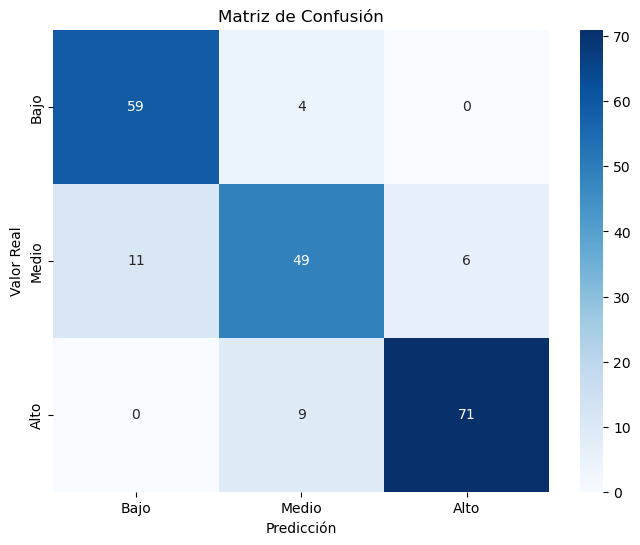

In [24]:
# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Bajo', 'Medio', 'Alto'], yticklabels=['Bajo', 'Medio', 'Alto'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()

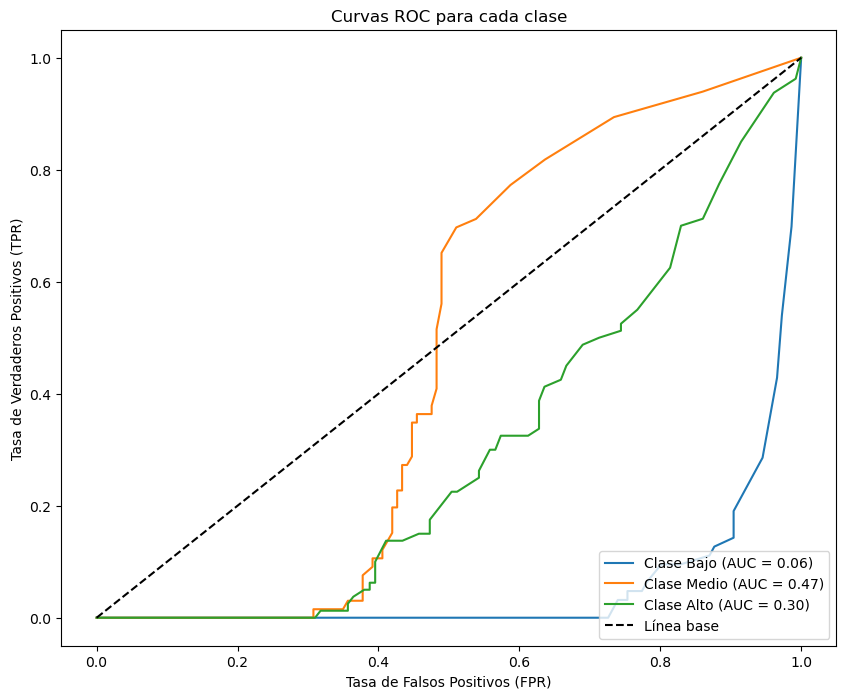

In [25]:
from sklearn.metrics import roc_curve, roc_auc_score, auc  # Asegúrate de incluir 'auc'
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Obtener las probabilidades predichas del clasificador para cada clase
y_pred_prob = clf.predict_proba(X_test)

# Binarizar las clases reales (y_test) para cada categoría
y_test_bin = label_binarize(y_categorico_test, classes=['Bajo', 'Medio', 'Alto'])

# Graficar las curvas ROC para cada clase
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(['Bajo', 'Medio', 'Alto']):
    # Calcular FPR (False Positive Rate) y TPR (True Positive Rate)
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)  # Calcular el AUC
    
    # Graficar la curva ROC para esta clase
    plt.plot(fpr, tpr, label=f'Clase {class_name} (AUC = {roc_auc:.2f})')

# Configurar la gráfica
plt.plot([0, 1], [0, 1], 'k--', label='Línea base')  # Línea diagonal
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC para cada clase')
plt.legend(loc='lower right')
plt.show()

In [26]:
# Calcular el AUC macro promedio
auc_macro = roc_auc_score(y_test_bin, y_pred_prob, average='macro')
print(f"AUC promedio macro: {auc_macro}")

AUC promedio macro: 0.27717474659863667


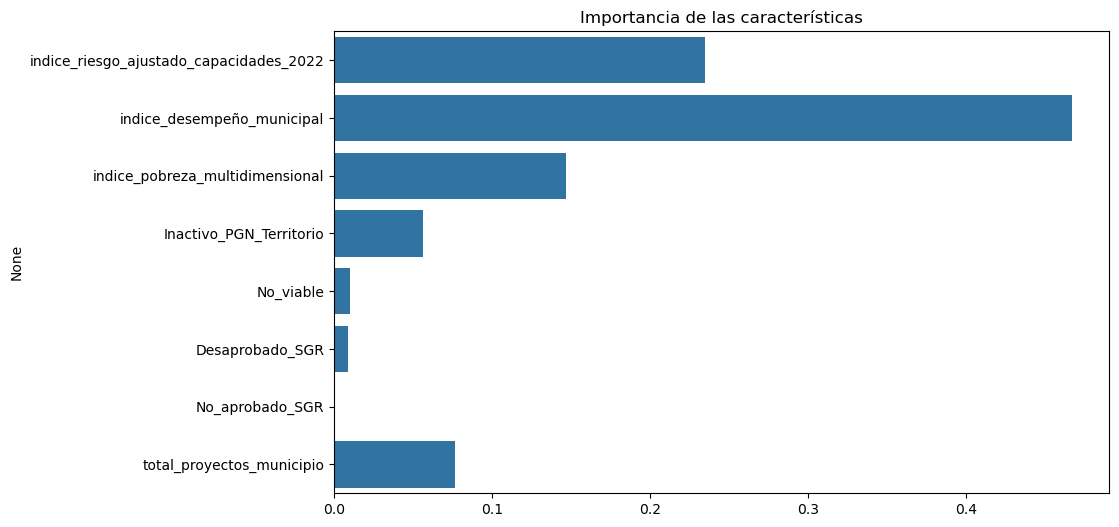

In [27]:
# Importnacia de las caracteristicas
importances = clf.feature_importances_
features = X_train.columns

# Graficar la importancia de las características
plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=features)
plt.title('Importancia de las características')
plt.show()

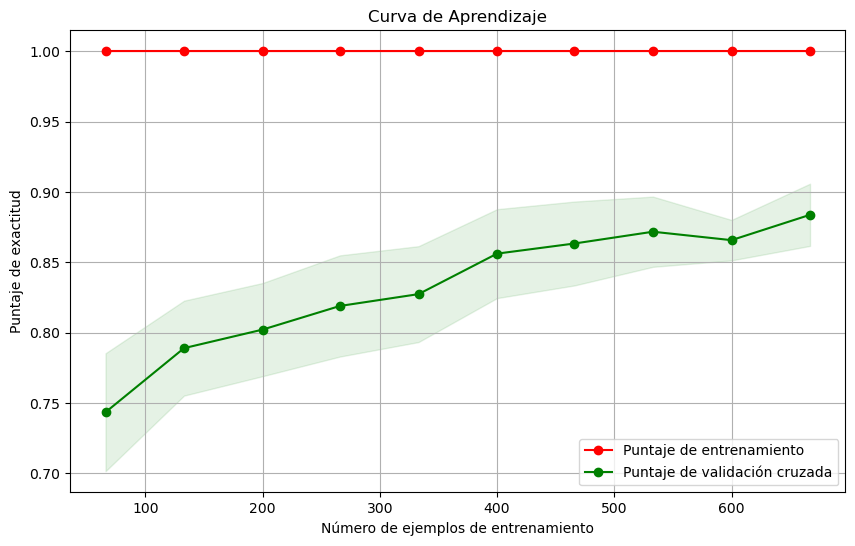

In [28]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# Calcular la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    clf, 
    X_train, 
    y_categorico_train,  # Asegúrate de usar etiquetas categóricas
    cv=5,  # Número de particiones para validación cruzada
    n_jobs=-1,  # Usar todos los núcleos disponibles
    train_sizes=np.linspace(0.1, 1.0, 10),  # Tamaño del conjunto de entrenamiento
    scoring="accuracy"  # Métrica de evaluación
)

# Calcular la media y desviación estándar de los puntajes
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Puntaje de entrenamiento")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Puntaje de validación cruzada")

# Sombras para la desviación estándar
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="g", alpha=0.1)

# Configurar la gráfica
plt.title('Curva de Aprendizaje')
plt.xlabel('Número de ejemplos de entrenamiento')
plt.ylabel('Puntaje de exactitud')
plt.legend(loc='best')
plt.grid()
plt.show()

In [32]:
# Realizar las predicciones de riesgo financiero
df['prediccion_riesgo'] = clf.predict(X)

# Ordenar los municipios por prediccion_riesgo
municipios_mas_riesgosos = df[['municipio', 'prediccion_riesgo']].sort_values(by='prediccion_riesgo', ascending=False)
municipios_menos_riesgosos = df[['municipio', 'prediccion_riesgo']].sort_values(by='prediccion_riesgo', ascending=True)

# Mostrar los municipios más riesgosos
print("\nMunicipios más riesgosos:")
print(municipios_menos_riesgosos.head(10))  # Los 10 municipios menos riesgosos


Municipios más riesgosos:
        municipio prediccion_riesgo
0          Silvia              Alto
337     El Carmen              Alto
722    San Marcos              Alto
333        Enciso              Alto
332  Hato Corozal              Alto
728        Salgar              Alto
327       Bolívar              Alto
325      Abriaquí              Alto
732      El Bagre              Alto
321       Gigante              Alto


In [34]:
# Contar la cantidad de municipios en cada categoría de riesgo
conteo_categorias = df['prediccion_riesgo'].value_counts()

# Mostrar los resultados
print("Conteo de municipios por categoría de riesgo:")
print(conteo_categorias)

Conteo de municipios por categoría de riesgo:
prediccion_riesgo
Alto     352
Bajo     351
Medio    340
Name: count, dtype: int64


C:\Users\david\AppData\Local\Temp\ipykernel_13960\2797799567.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


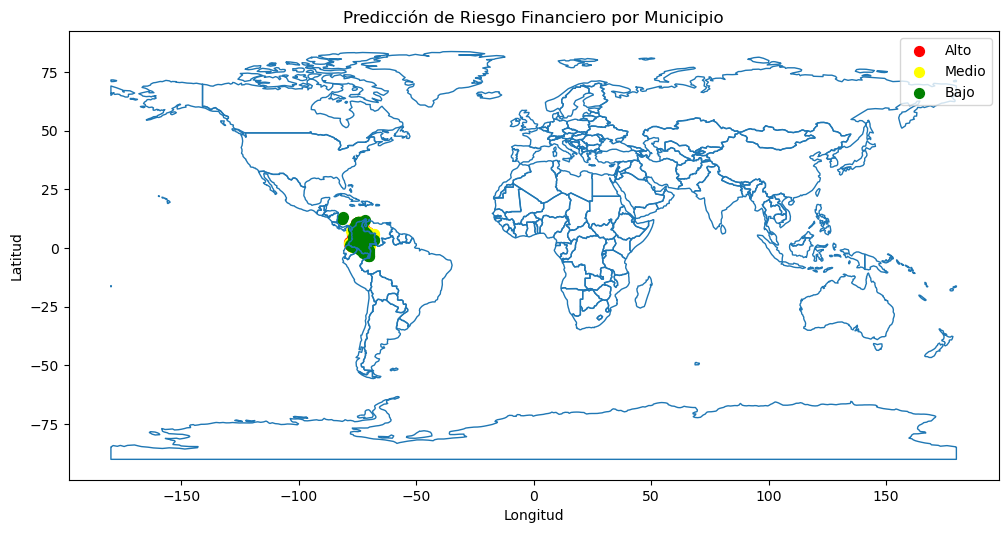

In [36]:
# Crear un GeoDataFrame
geometry = [Point(xy) for xy in zip(df['Longitud'], df['Latitud'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Crear un mapa base
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Graficar
fig, ax = plt.subplots(figsize=(12, 8))
world.boundary.plot(ax=ax, linewidth=1)
gdf[gdf['prediccion_riesgo'] == 'Alto'].plot(ax=ax, color='red', label='Alto', markersize=50)
gdf[gdf['prediccion_riesgo'] == 'Medio'].plot(ax=ax, color='yellow', label='Medio', markersize=50)
gdf[gdf['prediccion_riesgo'] == 'Bajo'].plot(ax=ax, color='green', label='Bajo', markersize=50)

# Configurar el gráfico
plt.title('Predicción de Riesgo Financiero por Municipio')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend()
plt.show()

In [37]:
import folium
from IPython.display import display
# Eliminar filas con NaN en las columnas 'Latitud' y 'Longitud'
df_clean = df.dropna(subset=['Latitud', 'Longitud'])

# Crear el mapa
mapa = folium.Map(location=[df_clean['Latitud'].mean(), df_clean['Longitud'].mean()], zoom_start=6)

# Agregar marcadores
for _, row in df_clean.iterrows():
    color = 'green' if row['prediccion_riesgo'] == 'Bajo' else 'yellow' if row['prediccion_riesgo'] == 'Medio' else 'red'
    folium.CircleMarker(location=(row['Latitud'], row['Longitud']),
                        radius=5,
                        color=color,
                        fill=True,
                        fill_opacity=0.6,
                        popup=row['municipio']).add_to(mapa)

# Mostrar el mapa en pantalla
display(mapa)

In [38]:
# Guardar el mapa como un archivo HTML
mapa.save('mapa_riesgo_financiero_ajustado.html')